## Data pre-processing
* import dependencies
* import data
* split data into training and testing sets
* create normalization layer 
* normalize input data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

np.random.seed(0)

# Read duty cycles file
duty_cycle_data = pd.read_csv('duty_cycle_values.csv',header=None)
duty_cycle_data = np.array(duty_cycle_data)

# Read magnetic field file
mag_field_data = pd.read_csv('magnetic_field_values.csv',header=None)
mag_field_data = np.array(mag_field_data)

# merge into a single dataset 
dataset = np.concatenate((duty_cycle_data,mag_field_data),axis=1)


# Define test and train datasets
np.random.shuffle(dataset)
train_dataset = dataset[0:int(np.floor(0.8*dataset.shape[0])),:]
test_dataset = dataset[int(np.floor(0.8*dataset.shape[0]))+1:,:]

# inputs are denoted with X and outputs with y
X_train = train_dataset[:,6:9]
y_train = train_dataset[:,0:6]
X_test = test_dataset[:,6:9]
y_test = test_dataset[:,0:6]


# Data normalization 
normalizer = tf.keras.layers.Normalization(axis=-1) # create normalization layer
normalizer.adapt(np.array(dataset[:,6:9])) # adapt normalization layer 
# X_train = normalizer(X_train) # normalize train input data
# X_test = normalizer(X_test) # normalize test input data

2023-08-23 07:44:27.416187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 07:44:27.858735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 07:44:27.861608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 07:44:29.263242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Create the model
Create the layers one by one and add them to the model.

In [2]:
# Define the model 
model = tf.keras.models.Sequential() # initialize the model
model.add(tf.keras.Input(shape=(3,),batch_size=64)) # input layer
model.add(tf.keras.layers.Normalization(axis=-1,mean=normalizer.mean, variance=normalizer.variance))
model.add(tf.keras.layers.Dense(64,activation='relu',kernel_initializer='he_uniform')) # first (and only) hidden layer
model.add(tf.keras.layers.Dense(6,activation = 'linear')) # output layer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # define the optimizer 
model.compile(loss='mse',optimizer=optimizer,metrics=['mae']) # compiler the model (set loss metric and optimizer)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (64, 3)                   0         
 tion)                                                           
                                                                 
 dense (Dense)               (64, 64)                  256       
                                                                 
 dense_1 (Dense)             (64, 6)                   390       
                                                                 
Total params: 646 (2.52 KB)
Trainable params: 646 (2.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Train the model
Also plot the loss vs epoch

Epoch 1/20
2603/2603 [==============================] - 5s 2ms/step - loss: 0.0364 - mae: 0.1018 - val_loss: 0.0037 - val_mae: 0.0408
Epoch 2/20
2603/2603 [==============================] - 5s 2ms/step - loss: 0.0028 - mae: 0.0311 - val_loss: 0.0021 - val_mae: 0.0238
Epoch 3/20
2603/2603 [==============================] - 5s 2ms/step - loss: 0.0019 - mae: 0.0184 - val_loss: 0.0015 - val_mae: 0.0132
Epoch 4/20
2603/2603 [==============================] - 4s 2ms/step - loss: 0.0016 - mae: 0.0124 - val_loss: 0.0014 - val_mae: 0.0107
Epoch 5/20
2603/2603 [==============================] - 4s 2ms/step - loss: 0.0015 - mae: 0.0104 - val_loss: 0.0013 - val_mae: 0.0098
Epoch 6/20
2603/2603 [==============================] - 4s 2ms/step - loss: 0.0015 - mae: 0.0095 - val_loss: 0.0013 - val_mae: 0.0100
Epoch 7/20
2603/2603 [==============================] - 5s 2ms/step - loss: 0.0014 - mae: 0.0093 - val_loss: 0.0013 - val_mae: 0.0090
Epoch 8/20
2603/2603 [==============================] - 5s 2ms

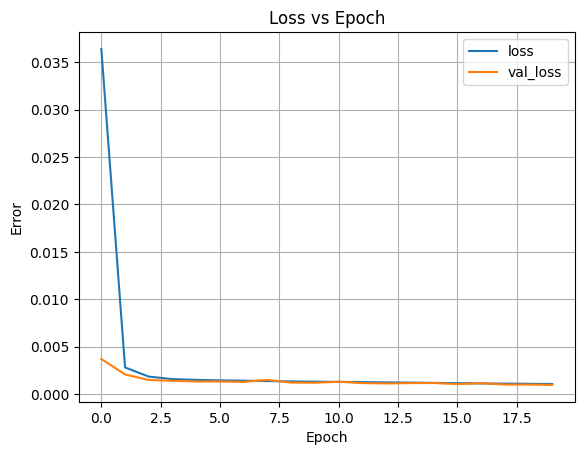

In [3]:
history = model.fit(X_train,y_train,epochs = 20,validation_split=0.2,shuffle=True)  

hist = pd.DataFrame(history.history)
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.title("MSE vs Epoch")

plot_loss(history)

## Test the model

In [4]:
mae_eval = model.evaluate(X_test,y_test)

814/814 [==============================] - 1s 1ms/step - loss: 0.0011 - mae: 0.0075


## Save the model in a file
Model is saved in a JSON file and weights are saved in a HDF5 format.

In [5]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Load and use the model (autonomous code block)
This code block is autonomous and it is meant to be copied into a new project that used the NN model saved above.

In [5]:
import tensorflow as tf
import numpy as np 
from time import time

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# Make a prediction and measure prediction time

DC = [-50.0,-50.0,-50.0]
start_time = time()
pred = loaded_model.predict(np.array(DC))
end_time = time()
elapsed_time = end_time - start_time 
print(elapsed_time)
print(pred)

Loaded model from disk
1/1 [==============================] - 0s 51ms/step
0.09102606773376465
[[ 0.9773302  -0.1210151  -0.07473248  0.9912209   0.97927034  0.06277037]]
